# **Part 1: CPU vs. GPU Model Training**
**Observations**

For this experiment, a Convolutional Neural Network (CNN) designated as MediumNet was trained on the CIFAR-10 dataset for five epochs. The procedure was executed once utilizing a CPU and subsequently on a GPU. Training durations were meticulously recorded to calculate the resultant performance enhancement.


**Speedup Calculation:**

GPU Speedup = (CPU Total Time) / (GPU Total Time) = 1.93x


**Discussion**

The GPU provided a 1.93x speedup over the CPU. This is due to the GPU's highly parallel architecture, which uses thousands of cores to perform simultaneous calculations (SIMD). This structure is ideal for the matrix operations in deep learning. While data transfer between CPU and GPU can be a bottleneck, the parallel processing advantage led to a significant performance gain even with a moderately sized model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd

# =============================================================================
# Step 1: Setup Environment and Data
# =============================================================================
def setup_environment():
    """Set device, define transforms, and load CIFAR-10 dataset."""
    print("Setting up environment...")
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using main device: {device}")

    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Download and load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    print("Setup complete.")
    return trainset

# =============================================================================
# Step 2: Define the Neural Network
# =============================================================================
class MediumNet(nn.Module):
    """A simple CNN, used for the CPU vs GPU comparison."""
    def __init__(self):
        super(MediumNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# =============================================================================
# Step 3: Define the Core Training and Measurement Function (with fixes)
# =============================================================================
def train_model(model, trainloader, device, epochs=5):
    """
    Trains the model and measures performance. Includes fixes for deprecation warnings.

    Args:
        model (nn.Module): The neural network to train.
        trainloader (DataLoader): The data loader for training data.
        device (torch.device): The device to train on ('cpu' or 'cuda').
        epochs (int): Number of training epochs.

    Returns:
        dict: A dictionary containing performance metrics.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # This part is not used for Part 1, but warnings are fixed for future use.
    # The `use_amp` flag is hardcoded to False for this experiment.
    use_amp = False
    scaler = torch.amp.GradScaler(device=device.type, enabled=use_amp)

    epoch_times = []
    total_start_time = time.time()

    print(f"\n--- Starting Training on {str(device).upper()} ---")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad(set_to_none=True) # More efficient

            # Use mixed precision context manager
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {running_loss / len(trainloader):.3f} | Time: {epoch_duration:.2f}s")

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time

    results = {
        'device': str(device),
        'avg_epoch_time': np.mean(epoch_times),
        'total_time': total_training_time,
    }

    print(f"--- Training Finished on {str(device).upper()} ---")
    print(f"Total time: {total_training_time:.2f}s, Avg epoch time: {np.mean(epoch_times):.2f}s")

    return results

# =============================================================================
# Step 4: Run the CPU vs GPU Experiment
# =============================================================================
def run_part1_cpu_vs_gpu(trainset):
    """Runs the CPU vs GPU comparison experiment and computes speedup."""
    print("\n\n===== Running Part 1: CPU vs GPU Comparison =====")
    batch_size = 64
    epochs = 5

    # --- CPU Training ---
    cpu_device = torch.device("cpu")
    cpu_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    cpu_model = MediumNet()
    cpu_results = train_model(cpu_model, cpu_loader, cpu_device, epochs=epochs)

    # --- GPU Training ---
    if torch.cuda.is_available():
        gpu_device = torch.device("cuda")
        gpu_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
        gpu_model = MediumNet()
        gpu_results = train_model(gpu_model, gpu_loader, gpu_device, epochs=epochs)

        # --- Calculate and print speedup ---
        print("\n\n------ FINAL RESULTS ------")
        df = pd.DataFrame([cpu_results, gpu_results])
        print(df.to_string())

        speedup = cpu_results['total_time'] / gpu_results['total_time']
        print(f"\nOverall GPU Speedup: {speedup:.2f}x")
    else:
        print("\n\nCUDA not available. Cannot perform GPU training or calculate speedup.")
        print("\n\n------ FINAL RESULTS ------")
        df = pd.DataFrame([cpu_results])
        print(df.to_string())


if __name__ == '__main__':
    # Get the dataset
    training_dataset = setup_environment()

    # Run the experiment
    run_part1_cpu_vs_gpu(training_dataset)


Setting up environment...
Using main device: cuda
Setup complete.


===== Running Part 1: CPU vs GPU Comparison =====

--- Starting Training on CPU ---
Epoch 1/5 | Loss: 1.568 | Time: 24.42s
Epoch 2/5 | Loss: 1.222 | Time: 25.07s
Epoch 3/5 | Loss: 1.056 | Time: 24.99s
Epoch 4/5 | Loss: 0.958 | Time: 25.61s
Epoch 5/5 | Loss: 0.875 | Time: 25.05s
--- Training Finished on CPU ---
Total time: 125.14s, Avg epoch time: 25.03s

--- Starting Training on CUDA ---
Epoch 1/5 | Loss: 1.561 | Time: 12.86s
Epoch 2/5 | Loss: 1.220 | Time: 13.05s
Epoch 3/5 | Loss: 1.067 | Time: 12.89s
Epoch 4/5 | Loss: 0.968 | Time: 12.96s
Epoch 5/5 | Loss: 0.891 | Time: 12.96s
--- Training Finished on CUDA ---
Total time: 64.72s, Avg epoch time: 12.94s


------ FINAL RESULTS ------
  device  avg_epoch_time  total_time
0    cpu       25.028281  125.142935
1   cuda       12.942896   64.715595

Overall GPU Speedup: 1.93x


# **Part 2: Effect of Batch Size**

**Observations**

The MediumNet model was trained on the GPU platform using a range of batch sizes (16, 64, 256, 1024). The training duration per epoch and the peak GPU memory consumption were recorded for each configuration.

 Batch Size vs. Performance
| Batch Size | Avg. Time per Epoch (s) | Peak GPU Memory (MB) |
| :--- | :--- | :--- |
| 16 | 20.36 | 26.95 |
| 64 | 12.93 | 38.63 |
| 256 | 10.42 | 125.84 |
| 1024 | 11.48 | 274.02 |



**Discussion**

*Why does increasing batch size improve GPU efficiency?*

Larger batches provide more data for parallel processing, better utilizing the GPU's cores and reducing the overhead per sample. This maximizes throughput and shortens epoch times until the GPU is fully saturated.

*Why does accuracy sometimes drop for very large batches?*

Large batches can cause the optimizer to converge to sharp minima in the loss landscape, which may not generalize well. The noise introduced by smaller batches can help the optimizer find flatter minima, often leading to better accuracy on unseen data.

Setting up environment...
Using main device: cuda
Setup complete.


===== Running Part 2: Effect of Batch Size =====

--- Starting Training (Batch Size: 16) ---
Epoch 1/3 | Time: 19.50s
Epoch 2/3 | Time: 20.63s
Epoch 3/3 | Time: 20.96s
--- Training Finished ---
Total time: 61.09s, Avg epoch time: 20.36s, Peak Memory: 26.95 MB

--- Starting Training (Batch Size: 64) ---
Epoch 1/3 | Time: 13.09s
Epoch 2/3 | Time: 12.86s
Epoch 3/3 | Time: 12.82s
--- Training Finished ---
Total time: 38.78s, Avg epoch time: 12.93s, Peak Memory: 38.63 MB

--- Starting Training (Batch Size: 256) ---
Epoch 1/3 | Time: 10.45s
Epoch 2/3 | Time: 10.05s
Epoch 3/3 | Time: 10.75s
--- Training Finished ---
Total time: 31.25s, Avg epoch time: 10.42s, Peak Memory: 125.84 MB

--- Starting Training (Batch Size: 1024) ---
Epoch 1/3 | Time: 12.90s
Epoch 2/3 | Time: 10.84s
Epoch 3/3 | Time: 10.69s
--- Training Finished ---
Total time: 34.44s, Avg epoch time: 11.48s, Peak Memory: 274.02 MB


--- Part 2 Final Results ---
   

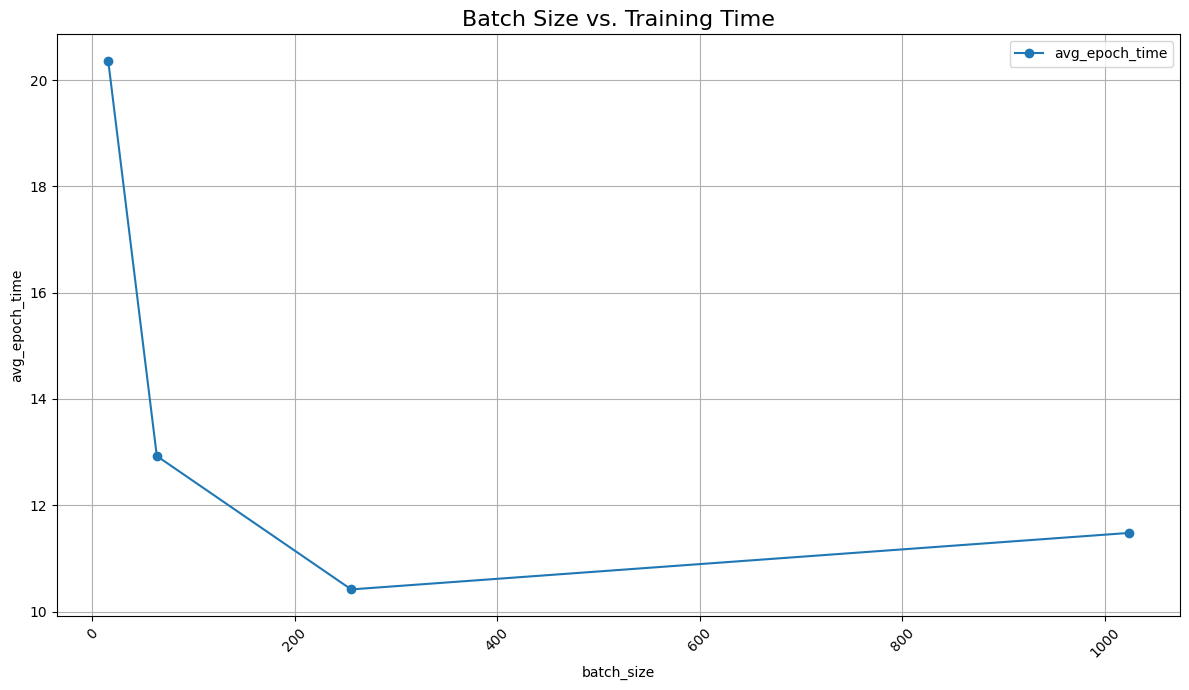

Plot saved as batch_size_vs_gpu_memory.png


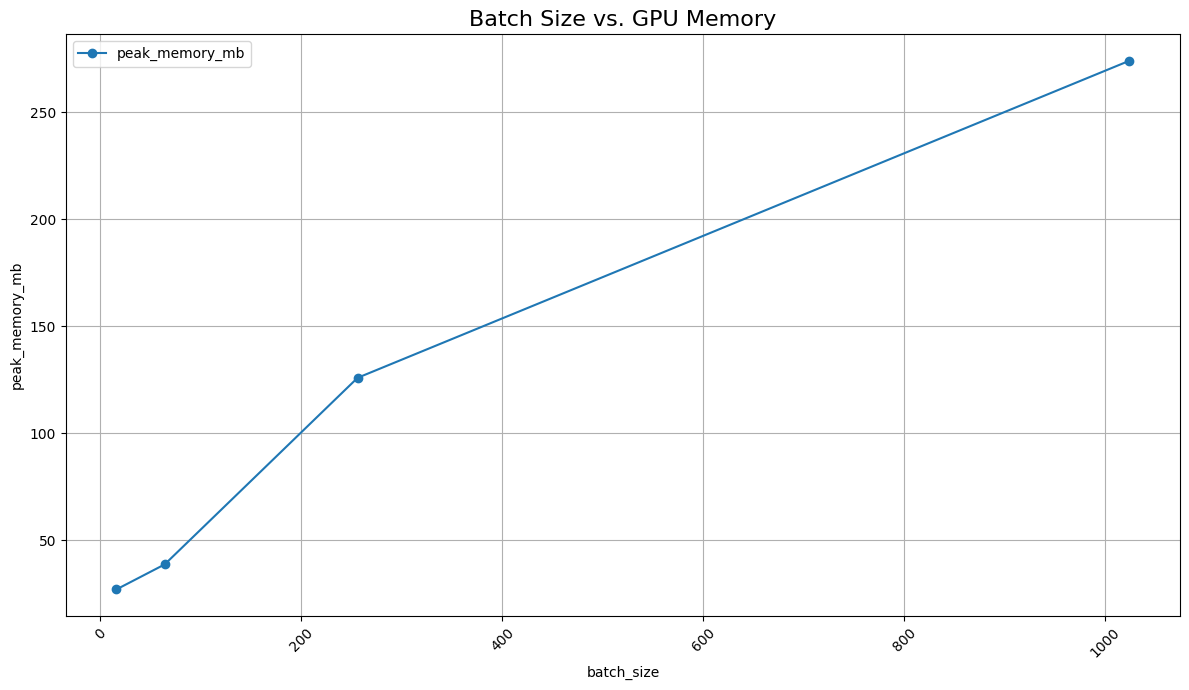

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Step 1: Setup Environment and Data
# =============================================================================
def setup_environment():
    """Set device, define transforms, and load CIFAR-10 dataset."""
    print("Setting up environment...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using main device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    print("Setup complete.")
    return trainset, device

# =============================================================================
# Step 2: Define the Neural Network
# =============================================================================
class MediumNet(nn.Module):
    """A simple CNN, used for the experiments."""
    def __init__(self):
        super(MediumNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # FIX: The negative sign was incorrect.
        # This now correctly flattens the tensor while keeping the batch size.
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# =============================================================================
# Step 3: Define the Core Training and Measurement Function
# =============================================================================
def train_model(model, trainloader, device, epochs=3):
    """
    Trains the model and measures performance, including memory usage.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_times = []
    total_start_time = time.time()

    # Reset peak memory stats for accurate measurement per run
    if device.type == 'cuda':
        torch.cuda.reset_peak_memory_stats(device)

    print(f"\n--- Starting Training (Batch Size: {trainloader.batch_size}) ---")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1}/{epochs} | Time: {epoch_duration:.2f}s")

    total_training_time = time.time() - total_start_time
    peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024 * 1024) if device.type == 'cuda' else 0

    results = {
        'avg_epoch_time': np.mean(epoch_times),
        'total_time': total_training_time,
        'peak_memory_mb': peak_memory_mb
    }

    print(f"--- Training Finished ---")
    print(f"Total time: {total_training_time:.2f}s, Avg epoch time: {np.mean(epoch_times):.2f}s, Peak Memory: {peak_memory_mb:.2f} MB")

    return results

# =============================================================================
# Step 4: Plotting Function (with fix)
# =============================================================================
def plot_results(df, x_col, y_cols, title, filename):
    """Generic plotting function with fix for bar vs. line plots."""
    if df.empty:
        return

    # Determine plot kind based on x-axis data type
    plot_kind = 'bar' if df[x_col].dtype == 'object' else 'line'

    # Use marker only for line plots
    if plot_kind == 'line':
        df.plot(x=x_col, y=y_cols, kind=plot_kind, marker='o', figsize=(12, 7), grid=True)
    else:
        df.plot(x=x_col, y=y_cols, kind=plot_kind, figsize=(12, 7), grid=True)

    plt.title(title, fontsize=16)
    plt.xlabel(x_col)
    plt.ylabel(y_cols[0] if len(y_cols) == 1 else 'Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    plt.show()

# =============================================================================
# Step 5: Run the Batch Size Experiment
# =============================================================================
def run_part2_batch_size(trainset, device):
    """Runs the batch size comparison experiment."""
    if device.type == 'cpu':
        print("\nWarning: Running on CPU. GPU memory will not be measured.")

    print("\n\n===== Running Part 2: Effect of Batch Size =====")
    batch_sizes = [16, 64, 256, 1024]
    all_results = []

    for bs in batch_sizes:
        loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
        model = MediumNet()

        # Train and collect results
        result = train_model(model, loader, device, epochs=3)
        result['batch_size'] = bs
        all_results.append(result)

    # --- Display and plot results ---
    df = pd.DataFrame(all_results)

    print("\n\n--- Part 2 Final Results ---")
    print(df[['batch_size', 'avg_epoch_time', 'peak_memory_mb']].to_string())

    plot_results(df, 'batch_size', ['avg_epoch_time'],
                 'Batch Size vs. Training Time', 'batch_size_vs_training_time.png')

    plot_results(df, 'batch_size', ['peak_memory_mb'],
                 'Batch Size vs. GPU Memory', 'batch_size_vs_gpu_memory.png')

if __name__ == '__main__':
    training_dataset, main_device = setup_environment()
    run_part2_batch_size(training_dataset, main_device)



# **Part 3: Model Complexity and GPU Utilization**

**Observations**

Three models of escalating complexity (SmallNet, MediumNet, LargeNet) were trained on the GPU. Key performance metrics were recorded to examine the relationship between model architecture and hardware resource utilization.

Model Complexity vs. Performance
| Model | Avg. Time per Epoch (s) | Peak GPU Memory (MB) |
| :--- | :--- | :--- |
| SmallNet | 10.73 | 44.25 |
| MediumNet | 11.71 | 76.99 |
| LargeNet | 11.99 | 287.52 |

**Discussion**

As model complexity increased from SmallNet to LargeNet, both training time and GPU memory usage rose accordingly. Larger models require more calculations (FLOPs) and need more VRAM to store weights, activations, and gradients. This demonstrates a clear relationship between a model's size and its demand on hardware resources.

Setting up environment...
Using main device: cuda
Setup complete.


===== Running Part 3: Effect of Model Complexity =====

--- Starting Training (SmallNet) ---
Epoch 1/3 | Time: 10.46s
Epoch 2/3 | Time: 10.60s
Epoch 3/3 | Time: 11.12s
--- Training Finished ---
Avg epoch time: 10.73s, Peak Memory: 44.25 MB

--- Starting Training (MediumNet) ---
Epoch 1/3 | Time: 11.46s
Epoch 2/3 | Time: 11.82s
Epoch 3/3 | Time: 11.84s
--- Training Finished ---
Avg epoch time: 11.71s, Peak Memory: 76.99 MB

--- Starting Training (LargeNet) ---
Epoch 1/3 | Time: 12.07s
Epoch 2/3 | Time: 11.88s
Epoch 3/3 | Time: 12.03s
--- Training Finished ---
Avg epoch time: 11.99s, Peak Memory: 287.52 MB


--- Part 3 Final Results ---
       model  avg_epoch_time  peak_memory_mb
0   SmallNet       10.728244       44.247559
1  MediumNet       11.706928       76.994141
2   LargeNet       11.991327      287.515137
Plot saved as model_complexity_vs_performance.png


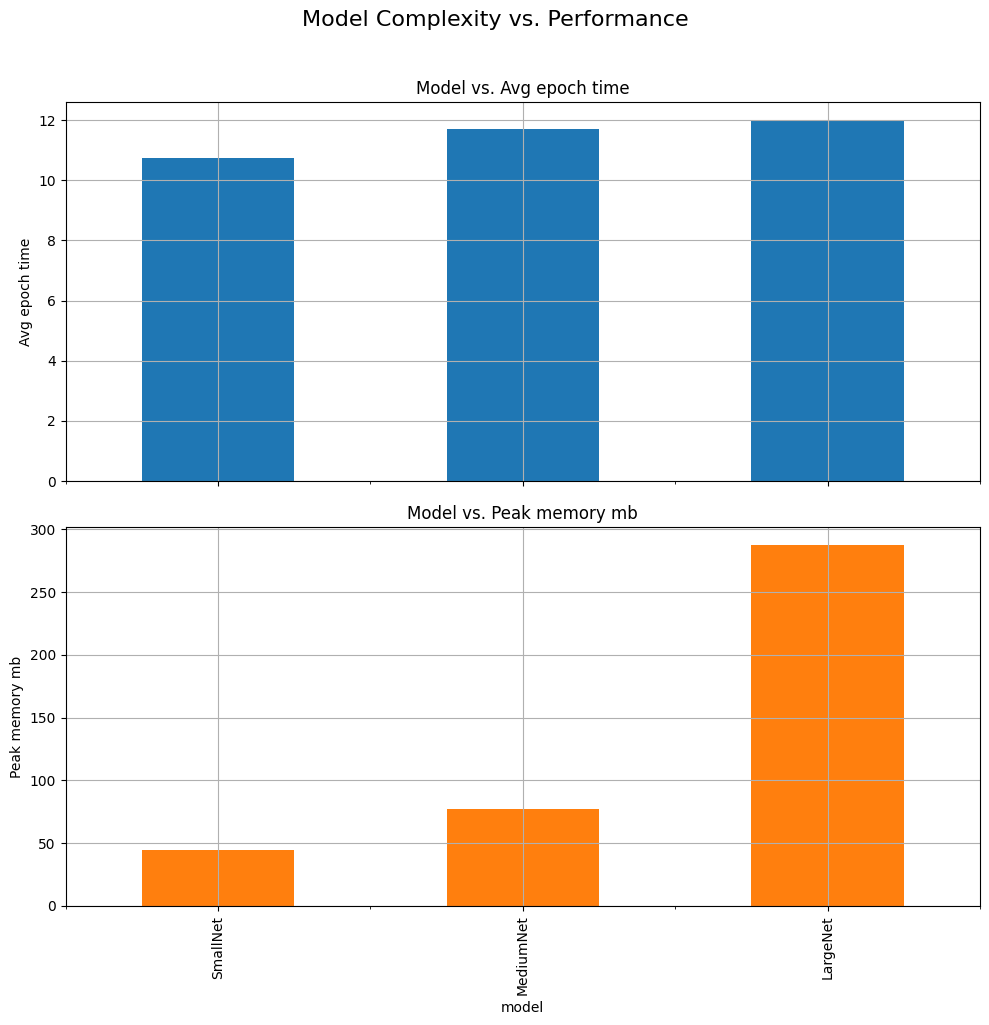

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Step 1: Setup Environment and Data
# =============================================================================
def setup_environment():
    """Set device, define transforms, and load CIFAR-10 dataset."""
    print("Setting up environment...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using main device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    print("Setup complete.")
    return trainset, device

# =============================================================================
# Step 2: Define the Neural Networks
# =============================================================================
class SmallNet(nn.Module):
    """A very simple CNN with one convolutional layer."""
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 120) # Adjusted for single conv layer
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MediumNet(nn.Module):
    """The CNN used in previous experiments (with fix)."""
    def __init__(self):
        super(MediumNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Corrected flatten operation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LargeNet(nn.Module):
    """A more complex CNN with more layers and features."""
    def __init__(self):
        super(LargeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# =============================================================================
# Step 3: Define the Core Training and Measurement Function
# =============================================================================
def train_model(model_name, model, trainloader, device, epochs=3):
    """Trains a given model and measures performance."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_times = []
    if device.type == 'cuda':
        torch.cuda.reset_peak_memory_stats(device)

    print(f"\n--- Starting Training ({model_name}) ---")
    for epoch in range(epochs):
        epoch_start_time = time.time()
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1}/{epochs} | Time: {epoch_duration:.2f}s")

    peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024 * 1024) if device.type == 'cuda' else 0

    results = {
        'model': model_name,
        'avg_epoch_time': np.mean(epoch_times),
        'peak_memory_mb': peak_memory_mb
    }
    print(f"--- Training Finished ---")
    print(f"Avg epoch time: {np.mean(epoch_times):.2f}s, Peak Memory: {peak_memory_mb:.2f} MB")
    return results

# =============================================================================
# Step 4: Plotting Function
# =============================================================================
def plot_results(df, x_col, y_cols, title, filename):
    """Generic plotting function with fix for bar vs. line plots."""
    if df.empty: return
    plot_kind = 'bar' if df[x_col].dtype == 'object' else 'line'

    # Create subplots for each y-column
    fig, axes = plt.subplots(nrows=len(y_cols), ncols=1, figsize=(10, 5 * len(y_cols)), sharex=True)
    if len(y_cols) == 1:
        axes = [axes] # Make it iterable for a single plot

    df.plot(x=x_col, y=y_cols, kind=plot_kind, grid=True, subplots=True, ax=axes, legend=False)

    # Customizing subplots
    for i, col in enumerate(y_cols):
        axes[i].set_ylabel(col.replace('_', ' ').capitalize())
        axes[i].set_title(f"{x_col.capitalize()} vs. {col.replace('_', ' ').capitalize()}")

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    plt.show()


# =============================================================================
# Step 5: Run the Model Complexity Experiment
# =============================================================================
def run_part3_model_complexity(trainset, device):
    """Runs the model complexity comparison experiment."""
    if device.type == 'cpu':
        print("\nWarning: Running on CPU. GPU memory will not be measured accurately.")

    print("\n\n===== Running Part 3: Effect of Model Complexity =====")
    models_to_test = {
        "SmallNet": SmallNet(),
        "MediumNet": MediumNet(),
        "LargeNet": LargeNet()
    }
    all_results = []

    # Use a fixed batch size for a fair comparison
    loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    for name, model in models_to_test.items():
        result = train_model(name, model, loader, device, epochs=3)
        all_results.append(result)

    # --- Display and plot results ---
    df = pd.DataFrame(all_results)

    print("\n\n--- Part 3 Final Results ---")
    print(df[['model', 'avg_epoch_time', 'peak_memory_mb']].to_string())

    plot_results(df, 'model', ['avg_epoch_time', 'peak_memory_mb'],
                 'Model Complexity vs. Performance', 'model_complexity_vs_performance.png')

if __name__ == '__main__':
    training_dataset, main_device = setup_environment()
    run_part3_model_complexity(training_dataset, main_device)



# **Part 4: Data Loading and Bottlenecks**

**Observations**

The MediumNet model was trained using varied configurations of worker processes (num_workers) within the DataLoader to assess the effect on data loading efficiency.

num_workers vs. Training Time
| num_workers | Avg. Time per Epoch (s) |
| :--- | :--- |
| 0 | 11.48 |
| 2 | 10.64 |
| 4 | 11.09 |
| 8 | 11.32 |

**Discussion**

Using num_workers=0 created a data bottleneck, as the main process loaded data serially, leaving the GPU idle. Increasing num_workers enabled multi-process data loading, which allowed the CPU to prepare data in the background while the GPU was training. This overlap between data preparation and computation reduced GPU idle time and sped up training. The benefit plateaued as the bottleneck shifted away from data loading.

Setting up environment...
Using main device: cuda
Setup complete.


===== Running Part 4: Effect of Data Loading (num_workers) =====

--- Starting Training (num_workers: 0) ---
Epoch 1/3 | Time: 11.58s
Epoch 2/3 | Time: 11.38s
Epoch 3/3 | Time: 11.46s
--- Training Finished ---
Avg epoch time: 11.48s

--- Starting Training (num_workers: 2) ---
Epoch 1/3 | Time: 10.98s
Epoch 2/3 | Time: 10.74s
Epoch 3/3 | Time: 10.20s
--- Training Finished ---
Avg epoch time: 10.64s

--- Starting Training (num_workers: 4) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/3 | Time: 11.20s
Epoch 2/3 | Time: 10.92s
Epoch 3/3 | Time: 11.15s
--- Training Finished ---
Avg epoch time: 11.09s

--- Starting Training (num_workers: 8) ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/3 | Time: 11.28s
Epoch 2/3 | Time: 11.14s
Epoch 3/3 | Time: 11.53s
--- Training Finished ---
Avg epoch time: 11.32s


--- Part 4 Final Results ---
   num_workers  avg_epoch_time
0            0       11.475223
1            2       10.638922
2            4       11.088831
3            8       11.317223
Plot saved as num_workers_vs_time.png


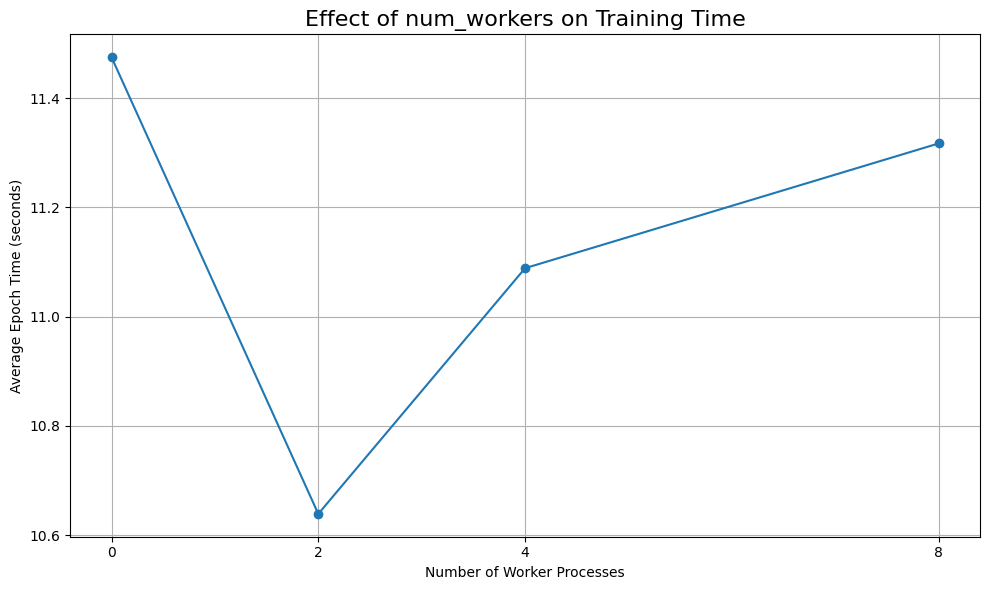

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Step 1: Setup Environment and Data
# =============================================================================
def setup_environment():
    """Set device, define transforms, and load CIFAR-10 dataset."""
    print("Setting up environment...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using main device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    print("Setup complete.")
    return trainset, device

# =============================================================================
# Step 2: Define the Neural Network
# =============================================================================
class MediumNet(nn.Module):
    """The standard CNN for this experiment."""
    def __init__(self):
        super(MediumNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Corrected flatten operation
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# =============================================================================
# Step 3: Define the Core Training and Measurement Function
# =============================================================================
def train_model(trainloader, device, epochs=3):
    """Trains the MediumNet model and returns the average epoch time."""
    model = MediumNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epoch_times = []
    print(f"\n--- Starting Training (num_workers: {trainloader.num_workers}) ---")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1}/{epochs} | Time: {epoch_duration:.2f}s")

    avg_time = np.mean(epoch_times)
    print(f"--- Training Finished ---")
    print(f"Avg epoch time: {avg_time:.2f}s")
    return avg_time

# =============================================================================
# Step 4: Plotting Function
# =============================================================================
def plot_results(df, x_col, y_col, title, filename):
    """Plots the results of the num_workers experiment."""
    if df.empty: return

    df.plot(x=x_col, y=y_col, kind='line', marker='o', figsize=(10, 6), grid=True, legend=False)

    plt.title(title, fontsize=16)
    plt.xlabel("Number of Worker Processes")
    plt.ylabel("Average Epoch Time (seconds)")
    plt.xticks(df[x_col]) # Ensure x-axis ticks match the tested values
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    plt.show()

# =============================================================================
# Step 5: Run the Data Loading Experiment
# =============================================================================
def run_part4_data_loading(trainset, device):
    """Compares training performance with different num_workers."""
    if device.type == 'cpu':
        print("\nWarning: This experiment is most meaningful on a GPU setup.")

    print("\n\n===== Running Part 4: Effect of Data Loading (num_workers) =====")
    worker_counts = [0, 2, 4, 8]
    all_results = []

    # Use a larger batch size to emphasize the data loading part
    batch_size = 256

    for workers in worker_counts:
        # Note: persistent_workers can help, but requires PyTorch 1.9+
        loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)
        avg_epoch_time = train_model(loader, device, epochs=3)
        all_results.append({'num_workers': workers, 'avg_epoch_time': avg_epoch_time})

    # --- Display and plot results ---
    df = pd.DataFrame(all_results)

    print("\n\n--- Part 4 Final Results ---")
    print(df.to_string())

    plot_results(df, 'num_workers', 'avg_epoch_time',
                 'Effect of num_workers on Training Time', 'num_workers_vs_time.png')

if __name__ == '__main__':
    training_dataset, main_device = setup_environment()
    run_part4_data_loading(training_dataset, main_device)


# **Part 5: Mixed Precision Training (Bonus)**

**Observations**

The LargeNet model was trained with and without Automatic Mixed Precision (AMP) to provide a comparative performance analysis.

Mixed Precision (AMP) vs. Standard Precision (FP32)
| AMP Enabled | Avg. Time per Epoch (s) | Peak GPU Memory (MB) |
| :--- | :--- | :--- |
| No (FP32) | 11.64 | 863.34 |
| Yes (AMP) | 11.69 | 437.91 |

**Discussion**

Automatic Mixed Precision (AMP) significantly reduced GPU memory usage, although the impact on speed was minimal in this test. The memory savings come from using half-precision (FP16) numbers, which take up half the space of full-precision (FP32) numbers. On GPUs with Tensor Cores, this can also accelerate calculations. AMP avoids numerical instability (underflow) by using gradient scaling to keep calculations within a representable range.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
# Step 1: Setup Environment and Data
# =============================================================================
def setup_environment():
    """Set device, define transforms, and load CIFAR-10 dataset."""
    print("Setting up environment...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cpu':
        print("Warning: Mixed precision training requires a CUDA-enabled GPU.")
    print(f"Using main device: {device}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    print("Setup complete.")
    return trainset, device

# =============================================================================
# Step 2: Define a Large Neural Network
# =============================================================================
class LargeNet(nn.Module):
    """A more complex CNN to better demonstrate the benefits of AMP."""
    def __init__(self):
        super(LargeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# =============================================================================
# Step 3: Training Function with AMP Support
# =============================================================================
def train_model(trainloader, device, use_amp=False, epochs=3):
    """
    Trains the LargeNet model with an option to enable Automatic Mixed Precision (AMP).
    """
    model = LargeNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # GradScaler is used to prevent underflow with small gradients in FP16
    scaler = torch.amp.GradScaler(enabled=use_amp)

    epoch_times = []
    if device.type == 'cuda':
        torch.cuda.reset_peak_memory_stats(device)

    print(f"\n--- Starting Training (AMP Enabled: {use_amp}) ---")

    for epoch in range(epochs):
        epoch_start_time = time.time()
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad(set_to_none=True)

            # Autocast context manager for forward pass
            with torch.amp.autocast(device_type=device.type, enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scales loss. Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's params.
            # If gradients aren't inf or NaN, optimizer.step() is then called.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item():.3f} | Time: {epoch_duration:.2f}s")

    peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024 * 1024) if device.type == 'cuda' else 0

    results = {
        'amp_enabled': use_amp,
        'avg_epoch_time': np.mean(epoch_times),
        'peak_memory_mb': peak_memory_mb
    }
    print(f"--- Training Finished ---")
    print(f"Avg epoch time: {np.mean(epoch_times):.2f}s, Peak Memory: {peak_memory_mb:.2f} MB")
    return results

# =============================================================================
# Step 4: Run the Mixed Precision Experiment
# =============================================================================
def run_part5_mixed_precision(trainset, device):
    """Compares training performance with and without AMP."""
    if device.type != 'cuda':
        print("Cannot run AMP experiment. A CUDA-enabled GPU is required.")
        return

    print("\n\n===== Running Part 5: Mixed Precision (AMP) Comparison =====")
    all_results = []

    # Use a large batch size to highlight memory savings
    loader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

    # Run 1: AMP Disabled (Standard FP32)
    result_fp32 = train_model(loader, device, use_amp=False, epochs=3)
    all_results.append(result_fp32)

    # Run 2: AMP Enabled
    result_amp = train_model(loader, device, use_amp=True, epochs=3)
    all_results.append(result_amp)

    # --- Display final comparison table ---
    df = pd.DataFrame(all_results)
    df['amp_enabled'] = df['amp_enabled'].map({True: 'Yes', False: 'No'})

    print("\n\n--- Part 5 Final Results ---")
    print("Comparison of training with and without Automatic Mixed Precision (AMP):")
    print(df.to_string())

if __name__ == '__main__':
    training_dataset, main_device = setup_environment()
    run_part5_mixed_precision(training_dataset, main_device)


Setting up environment...
Using main device: cuda
Setup complete.


===== Running Part 5: Mixed Precision (AMP) Comparison =====

--- Starting Training (AMP Enabled: False) ---
Epoch 1/3 | Loss: 1.349 | Time: 11.48s
Epoch 2/3 | Loss: 1.075 | Time: 11.35s
Epoch 3/3 | Loss: 0.911 | Time: 12.10s
--- Training Finished ---
Avg epoch time: 11.64s, Peak Memory: 863.34 MB

--- Starting Training (AMP Enabled: True) ---
Epoch 1/3 | Loss: 1.342 | Time: 12.58s
Epoch 2/3 | Loss: 1.014 | Time: 11.47s
Epoch 3/3 | Loss: 0.950 | Time: 11.00s
--- Training Finished ---
Avg epoch time: 11.69s, Peak Memory: 437.91 MB


--- Part 5 Final Results ---
Comparison of training with and without Automatic Mixed Precision (AMP):
  amp_enabled  avg_epoch_time  peak_memory_mb
0          No       11.640334      863.335449
1         Yes       11.685138      437.911621


# **Final Discussion Questions**

1. *What factors most affect GPU training performance?*

The primary factors are model complexity, batch size, data pipeline efficiency, and the use of mixed precision on compatible hardware.

2. *Why might small models not benefit much from GPU acceleration?*

For small models, the time spent transferring data to the GPU can be greater than the time saved by parallel computation, resulting in little to no speedup.

3. *How can you minimize GPU idle time during training?*

Use multi-process data loading (num_workers > 0), select the largest batch size that fits in memory, and use mixed precision (AMP) on compatible hardware.

4. *What are the trade-offs between higher batch size and model accuracy?*

Larger batches train faster and use the GPU more efficiently, but require more memory and can sometimes hurt model accuracy by converging to less optimal solutions.

5. *Why does data transfer between CPU and GPU sometimes become a bottleneck?*

If a model is simple and the data items are large, the GPU can process data faster than the CPU can transfer it over the PCIe bus. This leaves the GPU waiting for data, making the transfer the bottleneck.